In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt 
import cmocean
from scipy.interpolate import griddata 
from tqdm.notebook import tqdm
from altimetry_tools import Haversine, smooth_tracks, coarsen

In [2]:
# load dataset
x1 = xr.open_dataset('/Users/jakesteinberg/Desktop/neverworld/snapshots_00032505.nc', decode_times=False)  

In [3]:
# print to show dimensions 
x1

<xarray.Dataset>
Dimensions:  (time: 100, xh: 240, xq: 241, yh: 560, yq: 561, zi: 16, zl: 15)
Coordinates:
  * xq       (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.0 59.25 59.5 59.75 60.0
  * yh       (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time     (time) float64 3.250e+04 3.251e+04 3.252e+04 ... 3.3e+04 3.3e+04
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * yq       (yq) float64 -70.0 -69.75 -69.5 -69.25 ... 69.25 69.5 69.75 70.0
  * zi       (zi) float64 1.022e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
Data variables:
    u        (time, zl, yh, xq) float32 ...
    v        (time, zl, yq, xh) float32 ...
    e        (time, zi, yh, xh) float64 ...
    KE       (time, zl, yh, xh) float32 ...
Attributes:
    filename:          snapshots_00032505.nc
    title:             NeverWorld2
    associated_files:  area_t: static.nc
    grid_type:         regular
    grid_tile:         N/A

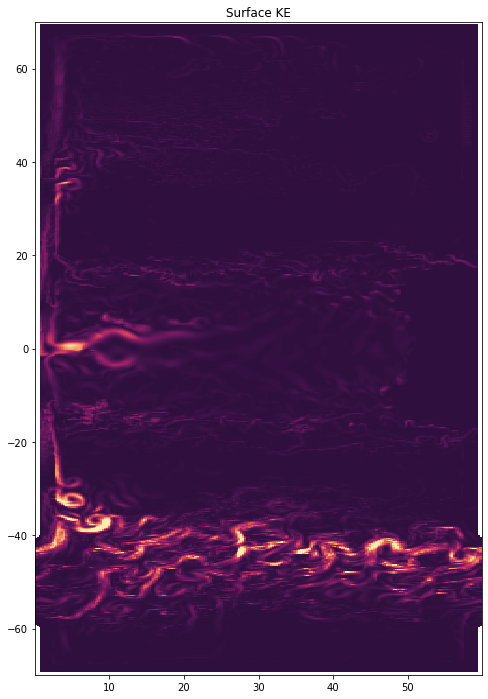

In [24]:
# sample plot of Surface KE 
f, ax = plt.subplots(1, 1, figsize=(8,12))
levs = np.linspace(7*10**(-8), 7*10**(-1), 100)
ax.pcolormesh(x1.xh, x1.yh, x1.KE.values[-1, 0], cmap = cmocean.cm.matter_r, \
              zorder=0, vmin=levs[0], vmax=levs[-1])
ax.set_title('Surface KE')
plt.show()

In [14]:
# extract meridional slice and compute distance 
lat = x1.yh.values
lon = x1.xh.values
lat_uv = x1.yh.values
# lon_uv = x1.xq.values
time = x1.time.values
e_0 = x1.e.values
e = e_0

lon_slice = np.array([10.125])
lon_slice_uv = np.array(10.25)
KE_slice = np.squeeze(x1.KE.values[:, 0, :, x1.xh == lon_slice])  # [MxN] M = time, N = distance 
e_slice = np.squeeze(e[:, 0, :, x1.xh == lon_slice])
u_slice = np.squeeze(x1.u.values[:, 0, :, x1.xq == lon_slice_uv])
v_slice = np.squeeze(x1.v.values[:, 0, :, x1.xh == lon_slice])

dist = np.nan * np.ones(len(lat))
dist_u = np.nan * np.ones(len(lat))
dist[0] = 0
dist_u[0] = 0
for i in range(1, len(lat)):
    # dist[i] = Haversine(lat[0], lon_slice[0], lat[i], lon_slice[0])  # in km
    dx = 1852 * 60 * np.cos(np.deg2rad(lat[i])) * (lon_slice[0] - lon_slice[0])
    dy = 1852 * 60 * (lat[i] - lat[i - 1]) 
    dist[i] = np.sqrt(dx**2 + dy**2) 
for i in range(1, len(lat)):
    dist_u[i] = Haversine(lat[0], lon_slice[0], lat[i], lon_slice[0])  # in km
    
dist_sum = np.cumsum(dist)
# 1/4 degree model (no real need to turn into km)      

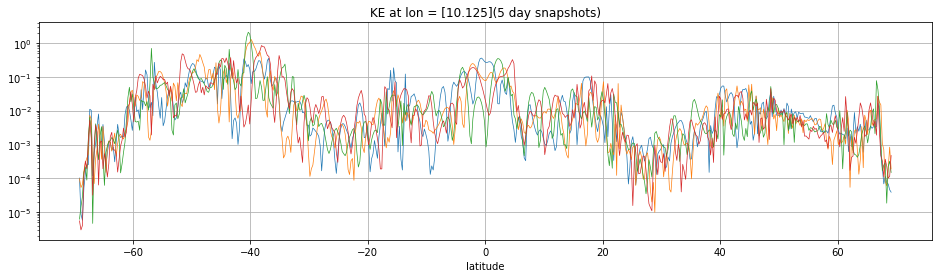

In [5]:
# sample KE (random snapshots to see variability)
f, ax = plt.subplots(1, 1, figsize=(16, 4))
time_snaps  = [0, 10, 20, 30]
for i in time_snaps:  #  range(np.shape(KE_slice)[0]):
    ax.plot(lat, KE_slice[i, :], linewidth=0.7)
# ax.set_ylim([10**(-5), 10])
ax.set_yscale('log')
# ax.set_ylim([-2, 2])
ax.set_title('KE at lon = ' + str(lon_slice) + ' (5 day snapshots)')
ax.set_xlabel('latitude')
ax.grid()
plt.show()

In [16]:
# reformat data to serve as adequate input into filtering and coarsening 
dist_0 = []
dist_0.append(dist_sum)
u_0 = []
u_0.append(u_slice)
lon_0 = []
lon_0.append(lon_slice * np.ones(len(lat)))
lat_0 = []
lat_0.append(lat)
time_0 = []
time_0.append(time)
track_0 = []
track_0.append(lon_slice * np.ones(len(lat)))

In [17]:
# Filter 
coarsening_factor = 4
filter_choice = 'sharp'  # gaussian 
nyquist_wavelength = np.pi
u_smooth, u_smooth = smooth_tracks(dist_0, u_0, u_0, lon_0, lat_0, time_0, \
              track_0, coarsening_factor, filter_choice, nyquist_wavelength)
    

Filter Half-Width = 
11 [0.16561428 0.15722541 0.1338254  0.10022574]
12 [0.16559081 0.15720193 0.13380193 0.10020227]
converged //
------------------------------------------------------------
for a coarsening factor of 4, recommend:
-- filter width of 25 grid cells (here = 694500.0 km)
------------------------------------------------------------


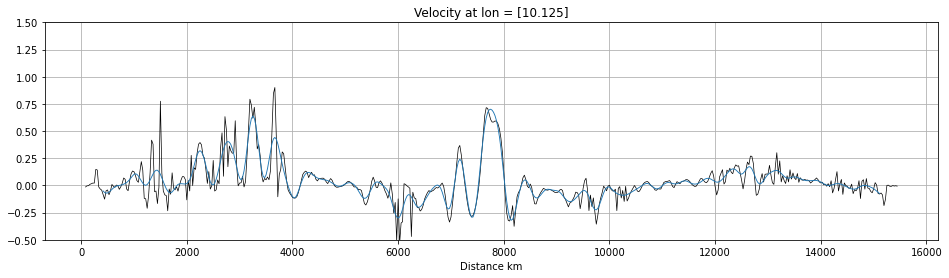

In [27]:
# plot filtered result 
f, ax = plt.subplots(1, 1, figsize=(16, 4))
for i in range(1):  #  range(np.shape(KE_slice)[0]):
    ax.plot(dist_sum/1000.0, u_slice[i, :], color='k', linewidth=0.7)
    ax.plot(dist_sum/1000.0, u_smooth[0][i, :], linewidth=0.9)
# ax.set_ylim([10**(-5), 10])
# ax.set_yscale('log')
ax.set_ylim([-.5, 1.5])
ax.set_title('Velocity at lon = ' + str(lon_slice))
ax.set_xlabel('Distance km')
ax.grid()
plt.show()

In [19]:
# Coarsen 
coarse_grid_out, coarse_lon_out, coarse_lat_out, coarse_sig_out = coarsen(dist_0, \
                                                                          lon_0, lat_0, \
                                                                          coarsening_factor, u_smooth)

/Users/jakesteinberg/Documents/CPT/altimetry_tools.py:395: RuntimeWarning: Mean of empty slice
  (this_dist < coarse_grid[j])], axis=1)


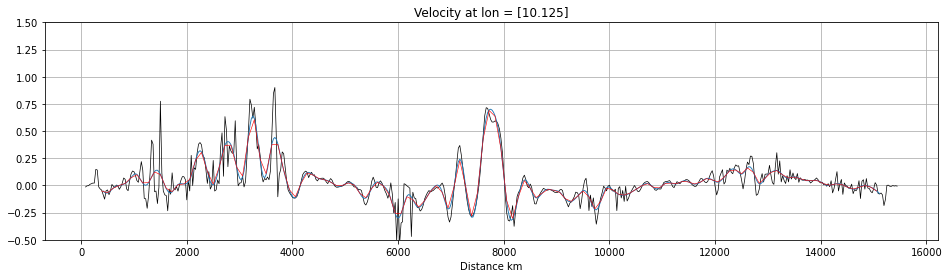

In [26]:
# plot combined results 
f, ax = plt.subplots(1, 1, figsize=(16, 4))
for i in range(1):  #  range(np.shape(KE_slice)[0]):
    ax.plot(dist_sum/1000.0, u_slice[i, :], color='k', linewidth=0.7)
    ax.plot(dist_sum/1000.0, u_smooth[0][i, :], linewidth=0.9)
    ax.plot(coarse_grid_out[0]/1000.0, coarse_sig_out[0][i, :], color='r', linewidth=0.6)
# ax.set_ylim([10**(-5), 10])
# ax.set_yscale('log')
ax.set_ylim([-.5, 1.5])
ax.set_title('Velocity at lon = ' + str(lon_slice))
ax.set_xlabel('Distance km')
ax.grid()
plt.show()

/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Degrees of freedom <= 0 for slice.
  This is separate from the ipykernel package so we can avoid doing imports until


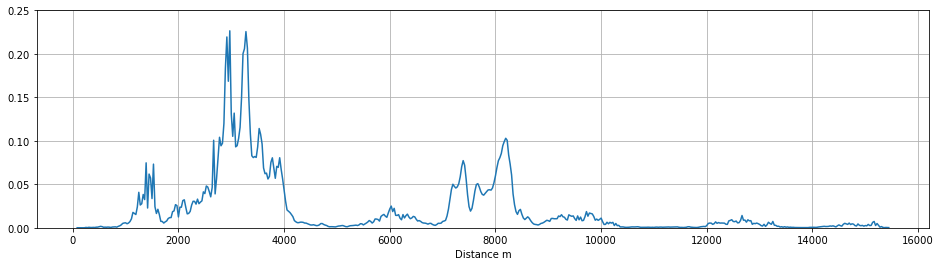

In [25]:
# show temporal variability along meridional section 
f, ax = plt.subplots(1, 1, figsize=(16,4))
ax.plot(dist_sum/1000.0, np.nanvar(u_slice, axis=0))
ax.set_ylim([0, 0.25])
# ax.set_xlim([15000, 20000])
ax.set_xlabel('Distance km')
ax.grid()
plt.show()

In [42]:
# test application of Ian's filter
from scipy import interpolate
from scipy import integrate

def filterSpec(N,dxMin,Lf,shape="Gaussian"):
    """
    Inputs: 
    N is the number of total steps in the filter
    dxMin is the smallest grid spacing - should have same units as Lf
    Lf is the filter scale, which has different meaning depending on filter shape
    shape can currently be one of two things:
        Gaussian: The target filter has kernel ~ e^{-|x/Lf|^2}
        Taper: The target filter has target grid scale Lf. Smaller scales are zeroed out. 
               Scales larger than pi*Lf/2 are left as-is. In between is a smooth transition.
    Note that the above are properties of the *target* filter, which are not the same as the actual filter.
    
    Outputs:
    NL is the number of Laplacian steps
    sL is s_i for the Laplacian steps; units of sL are one over the units of dxMin and Lf, squared
    NB is the number of Biharmonic steps
    sB is s_i for the Biharmonic steps; units of sB are one over the units of dxMin and Lf, squared
    """
    # Code only works for N>2
    if N <= 2:
        print("Code requires N>2")
        return 
    # First set up the mass matrix for the Galerkin basis from Shen (SISC95)
    M = (np.pi/2)*(2*np.eye(N-1) - np.diag(np.ones(N-3),2) - np.diag(np.ones(N-3),-2))
    M[0,0] = 3*np.pi/2
    # The range of wavenumbers is 0<=|k|<=sqrt(2)*pi/dxMin. Nyquist here is for a 2D grid. 
    # Per the notes, define s=k^2.
    # Need to rescale to t in [-1,1]: t = (2/sMax)*s -1; s = sMax*(t+1)/2
    sMax = 2*(np.pi/dxMin)**2
    # Set up target filter
    if shape == "Gaussian":
        F = lambda t: np.exp(-(sMax*(t+1)/2)*(Lf/2)**2)
    elif shape == "Taper":
        F = interpolate.PchipInterpolator(np.array([-1,(2/sMax)*(2/Lf)**2 -1,(2/sMax)*(np.pi/Lf)**2 -1,2]),np.array([1,1,0,0]))
    else:
        print("Please input a valid shape")
        return
    # Compute inner products of Galerkin basis with target
    b = np.zeros(N-1)
    points, weights = np.polynomial.chebyshev.chebgauss(N+1)
    for i in range(N-1):
        tmp = np.zeros(N+1)
        tmp[i] = 1
        tmp[i+2] = -1
        phi = np.polynomial.chebyshev.chebval(points,tmp)
        b[i] = np.sum(weights*phi*(F(points)-((1-points)/2 + F(1)*(points+1)/2)))
    # Get polynomial coefficients in Galerkin basis
    cHat = np.linalg.solve(M,b)
    # Convert back to Chebyshev basis coefficients
    p = np.zeros(N+1)
    p[0] = cHat[0] + (1+F(1))/2
    p[1] = cHat[1] - (1-F(1))/2
    for i in range(2,N-1):
        p[i] = cHat[i] - cHat[i-2]
    p[N-1] = -cHat[N-3]
    p[N] = -cHat[N-2]
    # Now plot the target filter and the approximate filter
    x = np.linspace(-1,1,251)
    k = np.sqrt((sMax/2)*(x+1))
    
    f, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 4))
    ax1.plot(k,F(x),k,np.polynomial.chebyshev.chebval(x,p))
    ax2.plot(k,F(x)-np.polynomial.chebyshev.chebval(x,p))
    plt.show()
    # Get roots of the polynomial
    r = np.polynomial.chebyshev.chebroots(p)
    # convert back to s in [0,sMax]
    s = (sMax/2)*(r+1)
    # Separate out the real and complex roots
    NL = np.size(s[np.where(np.abs(np.imag(r)) < 1E-12)]) 
    sL = np.real(s[np.where(np.abs(np.imag(r)) < 1E-12)])
    NB = (N - NL)//2
    sB_re,indices = np.unique(np.real(s[np.where(np.abs(np.imag(r)) > 1E-12)]),return_index=True)
    sB_im = np.imag(s[np.where(np.abs(np.imag(r)) > 1E-12)])[indices]
    sB = sB_re + sB_im*1j
    return NL,sL,NB,sB

grid step = 27.78km
filtering factor = 2


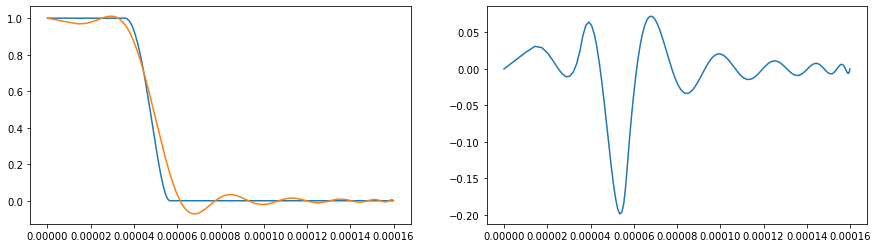

(11, 1)

In [106]:
N = 13
dxMin = dist_sum[2] - dist_sum[1]
print('grid step = ' + str(dxMin/1000.0) + 'km')
coarsening_factor = 2
Lf = dxMin*coarsening_factor
print('filtering factor = ' + str(coarsening_factor))
NL,sL,NB,sB = filterSpec(N, dxMin, Lf, "Taper")
NL,NB

In [66]:
dxMin

27780.0

In [109]:
test_data = u_slice[0, :]

def Laplacian(dxMin, data):
    L = np.nan * np.ones(len(data))
    for i in range(1, len(data) - 1):
        L[i-1:i+2] = (1/(dxMin**2))*np.array([1,-2,1])*data[i-1:i+2]
    return L

def Biharmonic(dxMin, data):
    B = np.nan * np.ones(len(data))
    for i in range(2, len(data) - 2):
        B[i-2:i+3] = (1/(dxMin**4))*np.array([1,-4,6,-4,1])*data[i-2:i+3]
    return B

dataBar = test_data.copy() # Initialize the filtering process
for i in range(NL):
    tempL = Laplacian(dxMin, dataBar) # Compute Laplacian
    dataBar = dataBar + (1/sL[i])*tempL # Update filtered field
for i in range(NB):
    tempL = Laplacian(dxMin, dataBar) # Compute Laplacian
    tempB = Biharmonic(dxMin, dataBar) # Compute Biharmonic. If boundary conditions permit you could replace this by
                                # tempB = Laplacian(tempL)
    dataBar = dataBar + (2*np.real(sB[i])/np.abs(sB[i])**2)*tempL + (1/np.abs(sB[i])**2)*tempB

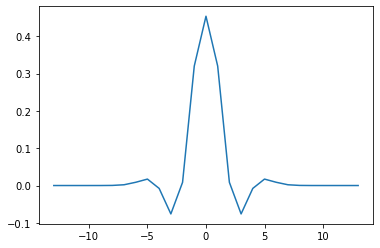

In [108]:
# sample to show filter weights (don't need these in the above application of this method)
L = (1/(dxMin**2))*np.array([1,-2,1])
B = (1/(dxMin**4))*np.array([1,-4,6,-4,1])
I = np.array([0,1,0])
w = ((1/(dxMin**2))*2*np.real(sB)*np.array([0,1,-2,1,0]) + B)/np.abs(sB)**2
w[2] = w[2] + 1
for i in range(11):
    w = np.convolve(I + (1/sL[i])*L,w)
plt.plot(np.arange(-13,14),w)

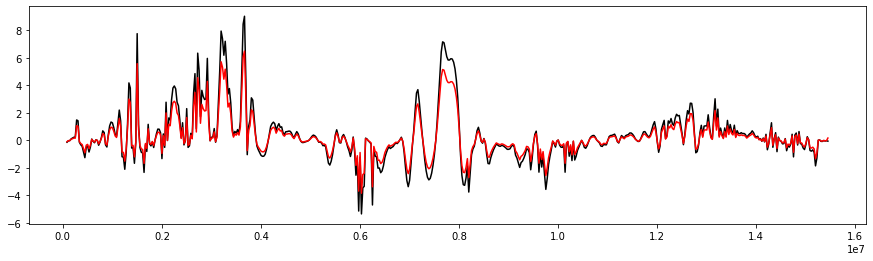

In [114]:
# not sure why 'filtered' data are an order of magnitude off 
f, ax = plt.subplots(1,1,figsize=(15,4))
ax.plot(dist_sum, test_data*10, color='k')
# ax.plot(dist_sum, test_lap*1000000000, color='r')
ax.plot(dist_sum, dataBar, color='r')
plt.show()

In [ ]:
# load data processed below (data here is interpolated ssh along altimeter tracks)
# to do next ... 
import pickle 
load_sat = pickle.load(open('/Users/jakesteinberg/Desktop/neverworld/j2_simulated_ke.p', 'rb'))

-- Take satellite tracks from satellite analysis and interpolate model fields to these points at each 5 day snapshot. Export the resulting SSH and treat at satellite in filtering library

Goal: Compare resulting KE estimate to actual model KE 

Problem: Current model resolution is 1/4 degree so if going to estimate KE from SSH gradients will be extremely coarse 
-- for now interpolate sqrt(KE) onto satellite tracks representing a speed like that calculated from along-track gradients 

The code below is run to interpolate and extract model surface fields to then process as we do with altimeter measurements 

In [307]:
# satellite tracks on model 
import pickle 
this_sat = 'j2'
filter_type = 'sharp'
load_sat = pickle.load(open('/Users/jakesteinberg/Documents/CPT/altimetry/' + \
                            this_sat + '_' + filter_type + '_processed.p', 'rb'))
lon_sat = load_sat['lon_record']
lat_sat = load_sat['lat_record']
track_sat = load_sat['track']

In [254]:
lon_w = 10
lon_e = 45
lat_s = 20
lat_n = 50
Lon, Lat = np.meshgrid(lon, lat)
Lon_f = Lon.flatten()
Lat_f = Lat.flatten()
points = np.concatenate((Lon_f[:, None], Lat_f[:, None]), axis=1)

/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less


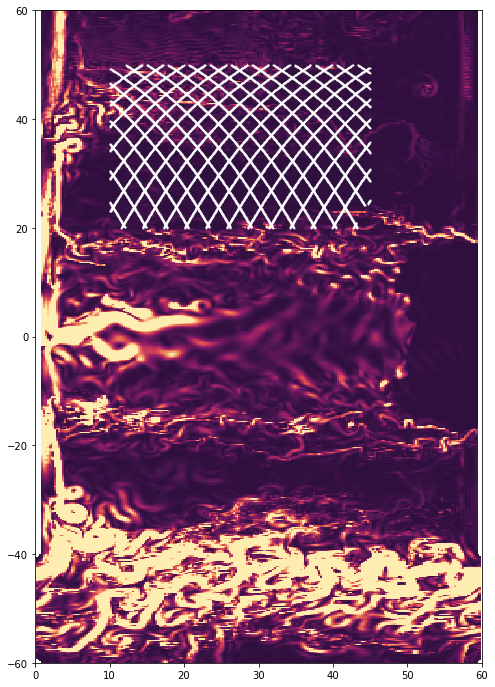

In [318]:
# --- plot and interpolate ssh (or say KE) to satellite lat/lon positions
# - say that satellite grid pattern is completed every time step...or every 5 days 
# - model fields are snapshots
lon_sim = []
lat_sim = []
dist_sim = []
e_sim = []
track = []
time_steps_i = 25  # np.shape(e)[0]  # each step is 5 days 
this_var = x1.KE.values[:, 0, :, :]

f, ax = plt.subplots(1, 1, figsize=(8,12))
levs = np.linspace(7*10**(-8), 7*10**(-2), 100)
ax.pcolormesh(x1.xh, x1.yh, x1.KE.values[-1, 0], cmap = cmocean.cm.matter_r, \
              zorder=0, vmin=levs[0], vmax=levs[-1])
count = 0
for i in tqdm(range(len(lon_sat))):
    # satellite lon,lat coordinates (consider places on coarser grid...now on 10 km grid)
    this_lon = (lon_sat[i] - 360) + 60
    this_lat = lat_sat[i]
    lon_lat_in = np.where((this_lon > lon_w) & (this_lon < lon_e) & (this_lat > lat_s) & (this_lat < lat_n))[0]
    if (len(lon_lat_in) > 20):
        ax.scatter(this_lon[lon_lat_in], lat_sat[i][lon_lat_in], s=1, color='w', zorder=2)
        # lat/lon
        lon_sim.append(this_lon[lon_lat_in])
        lat_sim.append(lat_sat[i][lon_lat_in])
        
        dx = np.nan * np.ones(len(lat_sim[count]) - 1)
        dy = np.nan * np.ones(len(lat_sim[count]) - 1)
        for k in range(1, len(lat_sim[count])):
            dx[k - 1] = 1852 * 60 * np.cos(np.deg2rad(lat_sim[count][k])) * (lon_sim[count][k] - lon_sim[count][k - 1])
            dy[k - 1] = 1852 * 60 * (lat_sim[count][k] - lat_sim[count][k - 1]) 
        dist = np.concatenate((np.array([0]), np.sqrt(np.cumsum(dx)**2 + np.cumsum(dy)**2)))
        dist_sim.append(dist)
        
        # variable we want to interpolate 
        this_e = np.nan * np.ones((np.shape(this_var)[0], len(this_lon[lon_lat_in])))
        for j in range(time_steps_i):  # loop over each time step 
            # values = np.squeeze(e[j, 0, :, :]).flatten()
            values = np.squeeze(this_var[j, :, :]).flatten()
            this_e[j, :] = griddata(points, values, \
                                    np.concatenate((this_lon[lon_lat_in][:, None], this_lat[lon_lat_in][:, None]), \
                                                   axis=1))
        track.append(track_sat[i])
        e_sim.append(this_e)
        count = count + 1
        
ax.set_xlim([0, 60])
ax.set_ylim([-60, 60])
plt.show()

In [314]:
count

37

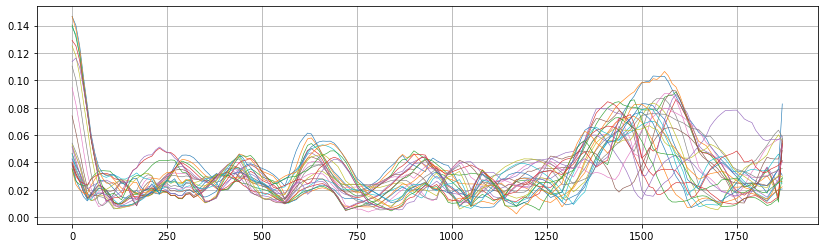

In [319]:
# dx = np.nan * np.ones(len(lat_sim[0]) - 1)
# dy = np.nan * np.ones(len(lat_sim[0]) - 1)
# for i in range(1, len(lat_sim[0])):
#     dx[i - 1] = 1852 * 60 * np.cos(np.deg2rad(lat_sim[0][i])) * (lon_sim[0][i] - lon_sim[0][i - 1])
#     dy[i - 1] = 1852 * 60 * (lat_sim[0][i] - lat_sim[0][i - 1]) 
# dist = np.concatenate((np.array([0]), np.sqrt(np.cumsum(dx)**2 + np.cumsum(dy)**2)))
test_i = 10
f, ax = plt.subplots(1, 1, figsize=(14, 4))
for i in range(np.shape(e_sim[test_i])[0]):
    ax.plot(dist_sim[test_i]/1000,np.sqrt(e_sim[test_i][i, :]), linewidth=0.6)
ax.grid()
plt.show()

In [322]:
save_sim = 1
if save_sim:
    outputs = {'dist': dist, \
               'ke': e_sim, \
                'time': time, \
                'lon': lon_sim, \
                'lat': lat_sim, \
                'track': track}
    pickle.dump(outputs, open('/Users/jakesteinberg/Desktop/neverworld/j2_simulated_ke.p', 'wb'))

In [ ]:
# tasks for analysis
# - smooth sla, u, v, ke
# - take u,v wavenumber and frequency spectra